Montaggio di Google Drive per accedere alla directory del Dataset

In [ ]:
!pip install adversarial-robustness-toolbox

In [2]:
!pip install image_dataset_loader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from pathlib import Path
import tensorflow as tf
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from art.estimators.classification import KerasClassifier
import image_dataset_loader
import numpy as np


tf.compat.v1.disable_eager_execution()


Si definisice una funzione che crea training set e test (con divisione 80-20) a partire dalla directory e una funzione che definisce il modello

In [5]:
def load_dataset():
  (train_data, train_label), (test_data, test_label) = image_dataset_loader.load('/content/drive/My Drive/Progetto_SD/images', ['train', 'test'],  x_dtype='uint8', y_dtype='uint32')

  train_data = (train_data-np.min(train_data))/(np.max(train_data)-np.min(train_data))
  test_data = (test_data-np.min(test_data))/(np.max(test_data)-np.min(test_data))

  return train_data, train_label, test_data, test_label, np.min(train_data), np.max(train_data)


def createModel():
  img_height = 128
  img_width = 128
  num_classes = 9

  model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model



Usiamo la funzione per ottenere test set e training set

In [6]:
training_set, training_label, test_set, test_label, min, max = load_dataset()

Instaziazione e addestramento del modello (senza difese)

In [ ]:

model = createModel()

history = model.fit(
  x = training_set,
  y = training_label,
  epochs = 10
)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Train on 4840 samples
Epoch 1/10
4840/4840 [==============================] - 82s 17ms/sample - loss: 1.4848 - accuracy: 0.4764
Epoch 2/10
4840/4840 [==============================] - 81s 17ms/sample - loss: 0.9792 - accuracy: 0.6700
Epoch 3/10
4840/4840 [==============================] - 78s 16ms/sample - loss: 0.7349 - accuracy: 0.7564
Epoch 4/10
4840/4840 [==============================] - 80s 17ms/sample - loss: 0.5277 - accuracy: 0.8233
Epoch 5/10
4840/4840 [==============================] - 79s 16ms/sample - loss: 0.3551 - accuracy: 0.8843
Epoch 6/10
4840/4840 [==============================] - 77s 16ms/sample - loss: 0.1816 - accuracy: 0.9488
Epoch 7/10
4840/4840 [==============================] - 85s 18ms/sample - loss: 0.1503 - accuracy: 0.9545
Epoch 8/10
4840/4840 [==============================] - 79s 16ms/sample - loss: 0.1011 - accuracy: 0.9684
Epoch 9/10
4840/4840 [==============================] - 79s 16ms/sample - loss: 0.0607 - accuracy: 0.9833
Epoch 10/10
4840/4840 [=

Inizio dell'attacco: si insierisce il modello all'interno di un Keras Classifier fornito dal toolbox. Il classificatore senza difese può essere ricreato da qualunque attaccante perchè il dataset è disponibile in rete.

In [ ]:
classifier = KerasClassifier(
    model=model,
    clip_values=(0.0, 1.0)
    )

Si definisce l'attacco con il FastGradientMethod

In [ ]:
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps = 5000,
    eps_step = 5000,
    minimal = True,
    norm = 1
    )

Generazione delle immagini di test con l'attacco

In [ ]:
test_set_adv = attack_fgsm.generate(x=test_set)

Di seguito la differenza tra immagine creata con l'attacco e una normale

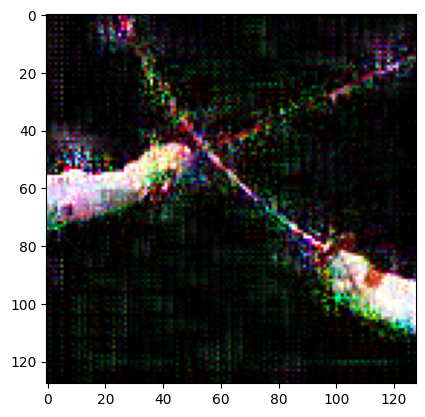

In [ ]:
plt.imshow(X=test_set_adv[3]) #immagine Adv

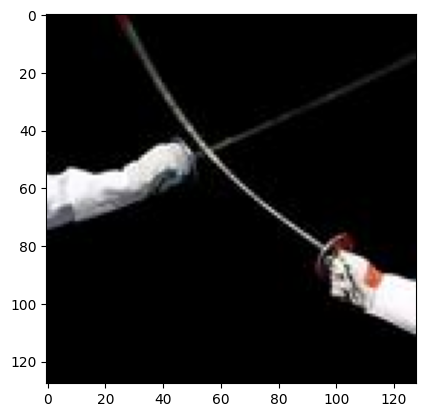

In [ ]:
plt.imshow(X=test_set[3]) #immagine dataset originale

Valutazione dei risultati

In [ ]:
score_adv = model.evaluate(
    x= test_set_adv,
    y= test_label
)

score_clean = model.evaluate(
    x= test_set,
    y= test_label
)

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

Clean test set loss: 1.79 vs adversarial set test loss: 36.05
Clean test set accuracy: 0.67 vs adversarial test set accuracy: 0.16


# Difesa - Rilevatore

Incapsuliamo il modello attaccante in un KerasClassifier.

In [ ]:
from art.defences.detector.poison import ActivationDefence

In [ ]:
# Initializing a defense object
#Analizza il dato e, se rileva poisoning, lo etichetta come dato avvelenato
defense = ActivationDefence(
    classifier=classifier,
    x_train=training_set,
    y_train=training_label
    )

Si genera un report in grado di identificare la percentuale di dati soggetti ad avvelenamento in ogni classe.

In [ ]:
# Detecting poisoned samples in the provided images
report, is_clean_reported = defense.detect_poison(
    nb_clusters=2,
    reduce="PCA",
    nb_dims=10)

In [ ]:
# Inspecting the report
print(report)

{'cluster_analysis': 'smaller', 'suspicious_clusters': 9, 'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.58, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.42, 'suspicious_cluster': True}}, 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.51, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.49, 'suspicious_cluster': True}}, 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.7, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.3, 'suspicious_cluster': True}}, 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.51, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.49, 'suspicious_cluster': True}}, 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.34, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.66, 'suspicious_cluster': False}}, 'Class_5': {'cluster_0': {'ptc_data_in_cluster': 0.57, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.43, 'suspicious_cluster': True

Come visibile dal report sopra, rileva l'attacco perché in ogni cluster ci sono dei dati sospettati come avvelenati.

# Difesa - Trainer

Si crea un classificatore robusto.

In [ ]:
# Initializing a robust classifier
robust_classifier = KerasClassifier(
    model=createModel(),
    clip_values=(min, max)
    )

Si inserisce anche l'attacco avversario nell'addestramento in modo da essere più robusto a questo tipo di attacco.

In [ ]:
from art.defences.trainer import AdversarialTrainer

# Initializing an adversarial trainer to train
# a robust model
trainer = AdversarialTrainer(
    classifier=robust_classifier,
    attacks=attack_fgsm,
    ratio=0.5
    )

In [ ]:
# Training the robust classifier
trainer.fit(
    x=training_set[:1213],
    y=training_label[:1213],
    nb_epochs=10
    )

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Si verificano i risultati.

In [ ]:
# Evaluating the performance of the robust classifier on adversarial images
score_robust_fgm = robust_classifier._model.evaluate(x=test_set_adv, y=test_label)

# Comparing test losses
print("------ TEST METRICS OF ROBUST VS VULNERABLE MODEL ON ADVERSARIAL SAMPLES ------")
print(f"Robust model test loss: {score_robust_fgm[0]:.2f} "
      f"vs vulnerable model test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Robust model test accuracy: {score_robust_fgm[1]:.2f} "
      f"vs vulnerable model test accuracy: {score_adv[1]:.2f}")

------ TEST METRICS OF ROBUST VS VULNERABLE MODEL ON ADVERSARIAL SAMPLES ------
Robust model test loss: 1.83 vs vulnerable model test loss: 36.05
Robust model test accuracy: 0.63 vs vulnerable model test accuracy: 0.16


In [ ]:
# Function for creating a figure and axes
def create_figure_axes(
    nrows,
    ncols,
    figsize
    ):
    # Creating a figure and axes
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize
        )

    # Returning the figure and axes
    return fig, axes

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


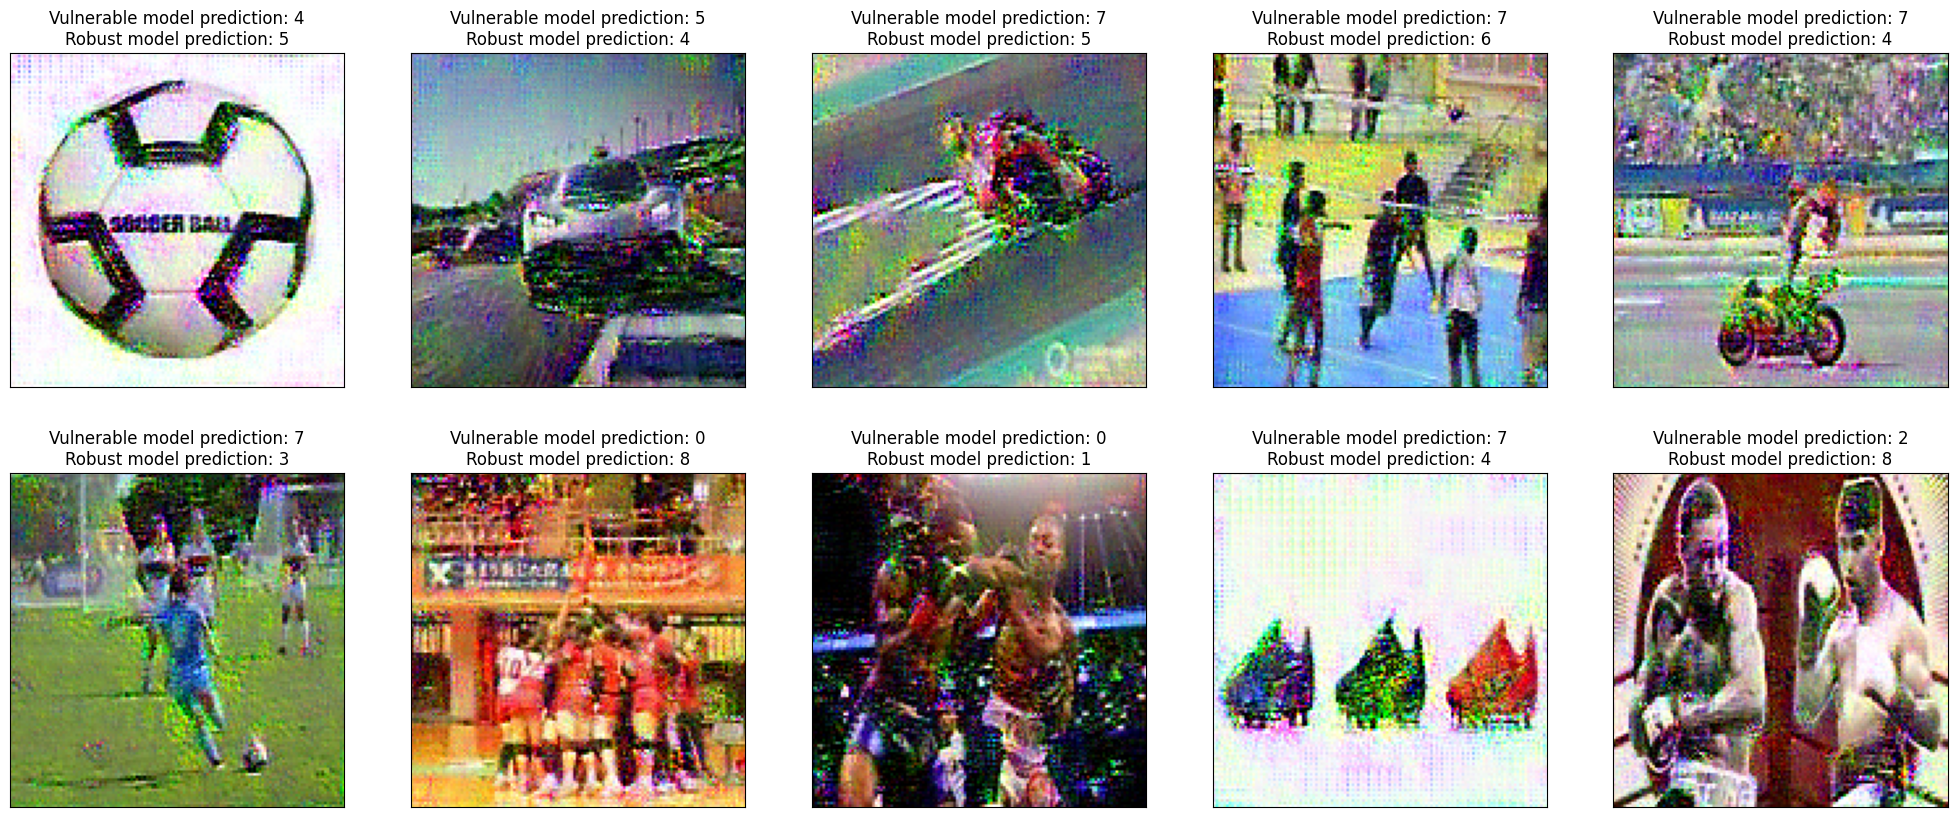

In [ ]:
# Setting the number of rows and columns for the plot
nrows=2
ncols=5

# Creating a plot figure and axes for samples
fig, axes = create_figure_axes(
    nrows=nrows,
    ncols=ncols,
    figsize=(25, 10)
    )

# Getting predictions for adversarial samples
victim_predictions = classifier.predict(x=test_set_adv)
robust_predictions = robust_classifier.predict(x=test_set_adv)

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting adversarial images
# along with their predictions
for i in range(nrows):
    for j in range(ncols):
        # Plotting the current image
        axes[i, j].imshow(test_set_adv[counter])

        # Setting axis title
        axes[i, j].set_title(label=f"Vulnerable model prediction: {np.argmax(victim_predictions[counter])}\n"
                                   f"Robust model prediction: {np.argmax(robust_predictions[counter])}")

        # Disabling axis ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1